# Scoring project : churn prediction

In [550]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder, StandardScaler
import missingno as msno
import matplotlib.pyplot as plt 
import plotly.graph_objects as go 
from plotly.subplots import make_subplots
import seaborn as sns
import warnings
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score



## Data analysis

### Import and analyzing

In [551]:
df = pd.read_csv('../data/data.csv')
df.head()

,id,gender,customer_senior,customer_partner,dependent_family,month_tenure,phone_subscription,multiple_line,internet_type,online_security,...,device_protection_plan,techinal_support,streaming_tv,streaming_movie,contract_type,paperless_billing,payment_method_type,amount_charges_monthly,amount_total_charges,churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.50,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes


In [552]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 21 columns):
 #   Column                  Non-Null Count  Dtype  
---  ------                  --------------  -----  
 0   id                      7043 non-null   object 
 1   gender                  7043 non-null   object 
 2   customer_senior         7043 non-null   int64  
 3   customer_partner        7043 non-null   object 
 4   dependent_family        7043 non-null   object 
 5   month_tenure            7043 non-null   int64  
 6   phone_subscription      7043 non-null   object 
 7   multiple_line           7043 non-null   object 
 8   internet_type           7043 non-null   object 
 9   online_security         7043 non-null   object 
 10  backup_service_online   7043 non-null   object 
 11  device_protection_plan  7043 non-null   object 
 12  techinal_support        7043 non-null   object 
 13  streaming_tv            7043 non-null   object 
 14  streaming_movie         7043 non-null   

In [553]:
# Check for duplicates in ID
duplicates = df["id"].duplicated().any()
duplicates

False

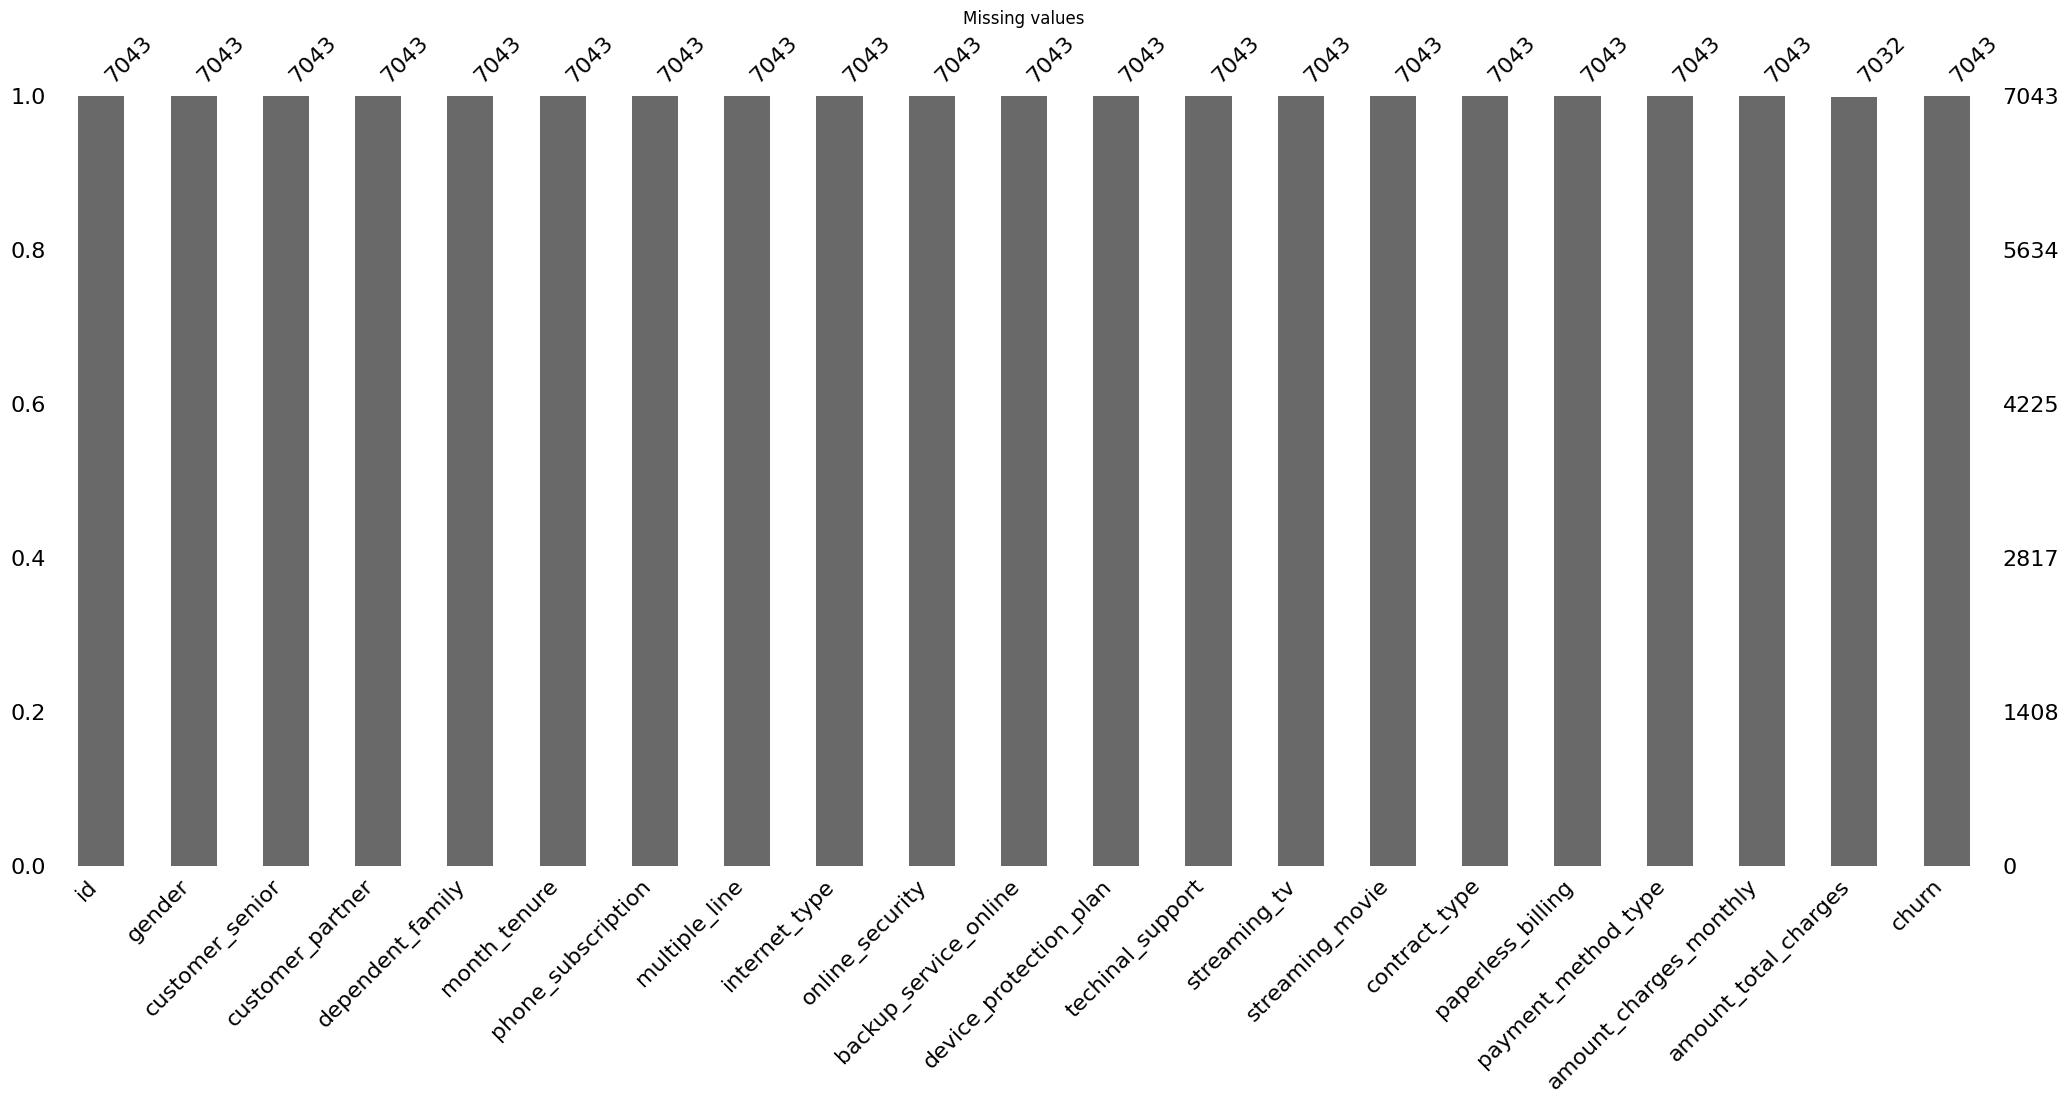

In [554]:
# Check for missing values
msno.bar(df)
plt.title("Missing values")
plt.show()

## Features distribution

In [555]:
df_shorten = df.drop(columns=["id", "churn"])
df_shorten = df_shorten.astype({"customer_senior": "object"})

cat_columns = [col for col in df_shorten.select_dtypes(include=np.object_).columns][1:-1]
num_columns = [col for col in df_shorten.select_dtypes(include=[np.int64, np.float64]).columns]
print(f"Total features: {len(df_shorten.columns)}\nCategorical features: {len(cat_columns)}\nNumerical features: {len(num_columns)}\n`id` and `churn` are excluded from these lists.")

Total features: 19
Categorical features: 14
Numerical features: 3
`id` and `churn` are excluded from these lists.


### Mapping

In [556]:
mapping_dict = {
    "gender": {
        "Male": 1,
        "Female": 0
    },
    "customer_senior": {
        1: 1,
        0: 0
    },
    "internet_type": {
        "Fiber optic": 2,
        "DSL": 1,
        "No": 0
    },
    "contract_type": {
        "Two year": 2,
        "One year": 1,
        "Month-to-month": 0
    },
    "payment_method_type": {
        "Electronic check": 3,
        "Mailed check": 2,
        "Bank transfer (automatic)": 1,
        "Credit card (automatic)": 0
    },
    "multiple_line" : {
        "Yes": 2,
        "No": 1,
        "No phone service": 0
    },
    "binary": {
        "Yes": 1,
        "No": 0
    },
    "multiple" : {
        "Yes": 2,
        "No": 1,
        "No internet service": 0
    }
}

In [557]:
df_mapped = df.copy()

for col in df_mapped:
    if col in mapping_dict.keys():
        df_mapped[col] = df_mapped[col].map(mapping_dict[col])
    else:
        if df_mapped[col].nunique() == 2:
            df_mapped[col] = df_mapped[col].map(mapping_dict["binary"])
        elif df_mapped[col].nunique() == 3:
            df_mapped[col] = df_mapped[col].map(mapping_dict["multiple"])

df_mapped

,id,gender,customer_senior,customer_partner,dependent_family,month_tenure,phone_subscription,multiple_line,internet_type,online_security,...,device_protection_plan,techinal_support,streaming_tv,streaming_movie,contract_type,paperless_billing,payment_method_type,amount_charges_monthly,amount_total_charges,churn
0,7590-VHVEG,0,0,1,0,1,0,0,1,1,...,1,1,1,1,0,1,3,29.85,29.85,0
1,5575-GNVDE,1,0,0,0,34,1,1,1,2,...,2,1,1,1,1,0,2,56.95,1889.50,0
2,3668-QPYBK,1,0,0,0,2,1,1,1,2,...,1,1,1,1,0,1,2,53.85,108.15,1
3,7795-CFOCW,1,0,0,0,45,0,0,1,2,...,2,2,1,1,1,0,1,42.30,1840.75,0
4,9237-HQITU,0,0,0,0,2,1,1,2,1,...,1,1,1,1,0,1,3,70.70,151.65,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,1,0,1,1,24,1,2,1,2,...,2,2,2,2,1,1,2,84.80,1990.50,0
7039,2234-XADUH,0,0,1,1,72,1,2,2,1,...,2,1,2,2,1,1,0,103.20,7362.90,0
7040,4801-JZAZL,0,0,1,1,11,0,0,1,2,...,1,1,1,1,0,1,3,29.60,346.45,0
7041,8361-LTMKD,1,1,1,0,4,1,2,2,1,...,1,1,1,1,0,1,2,74.40,306.60,1


In [558]:
import plotly.graph_objects as go 
from plotly.subplots import make_subplots

cor_matrix = df_mapped.drop(columns='id').corr().round(2)

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"type": "heatmap"}]])

fig.add_trace(go.Heatmap(z=cor_matrix.values, x=cor_matrix.columns, y=cor_matrix.columns, colorscale='Viridis'), row=1, col=1)

fig.update_layout(title='Correlation Matrix', width=700, height=700, template="plotly_dark")
fig.show()

**Some coments on the correlation matrix :**

> *Some correlations are hard to interpret because of the categorical variables, but still it helps us to understand the link between the variables and to highlit them.*

- `streaming_movie` and `streaming_tv`: strong positive correlation (0.81), the kind of service is the same. We could assume that having access to one of those services implies having access to the other one.
- all the features related to the internet services are highly correlated.
- `contract_type` and `month_tenure`: strong positive correlation (0.67), if the contract of a customer is 2 years it is therefore logical that the number of total months the customer has been with the company increase.
- `month_tenure` and `amount_total_charges`: strong positive correlation (0.83), the number of months spent by a customer in the company will therefore increase the total amout of charges of the customer.
- `multiple_lines` and `phone_subscription`: in the possible answers for `multiple_lines` there is the option "No phone service" which highly relates to the second feature.

### Numerical variables

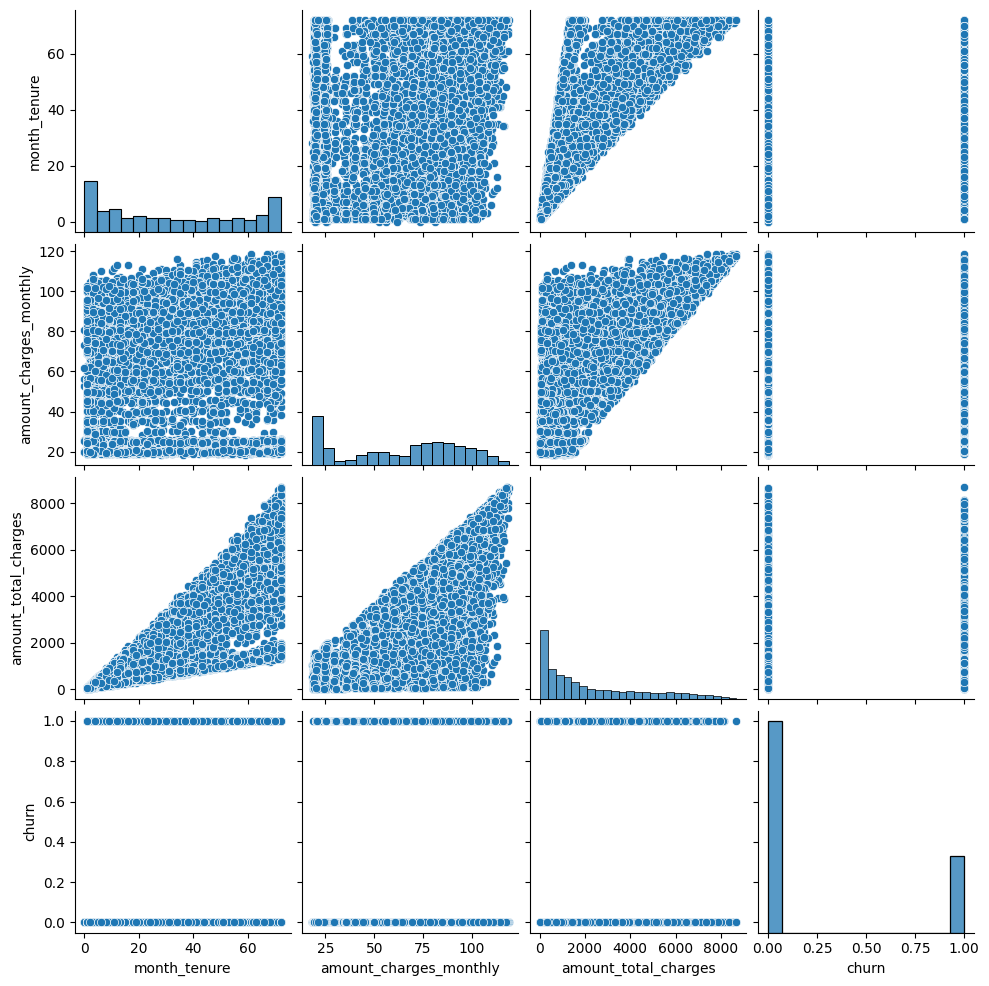

In [559]:
warnings.filterwarnings("ignore", category=FutureWarning, message=".*use_inf_as_na option is deprecated.*")

col = num_columns + ["churn"]

sns.pairplot(df_mapped[col])
plt.show()

In [560]:
n_col = len(num_columns)
col_width = [1/n_col for i in range(n_col)]
col_spec = [{"type": "bar"} for i in range(n_col)]

fig = make_subplots(
    rows=1,
    cols=n_col,
    column_widths=col_width,
    specs=[col_spec]
)

for i in range(n_col):
    col = num_columns[i]
    fig.add_trace(go.Box(y=df[col], name=col, boxmean="sd"), row=1, col=i+1)

fig.update_layout(title="Numerical variables distributions", template="plotly_dark")
fig.update_xaxes(tickangle=45)
fig.show()


### Categorical variables

/var/folders/4q/wlkm41x57nv0n4qhnyv84kjc0000gn/T/ipykernel_16080/4241154209.py:14: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



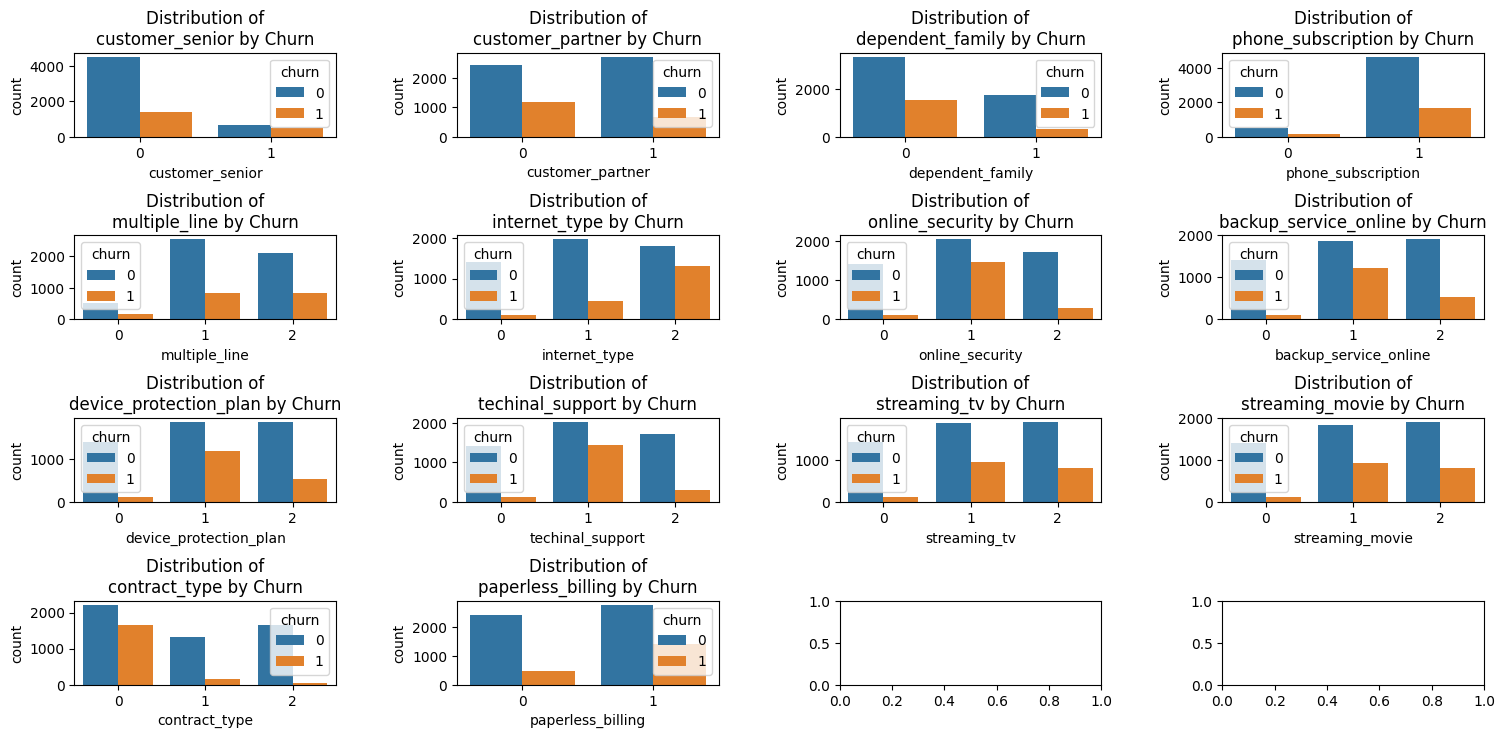

In [561]:
n_plots = len(cat_columns)
n_cols = 4
n_rows = (n_plots + n_cols-1) // n_cols

fig, ax = plt.subplots(n_rows, n_cols, figsize=(16,8), squeeze=False)
fig.tight_layout(pad=5.0)

for i, col in enumerate(cat_columns):
    row = i // n_cols
    col_pos = i % n_cols
    sns.countplot(x=col, hue="churn", data=df_mapped, ax=ax[row, col_pos])
    ax[row, col_pos].set_title(f"Distribution of\n{col} by Churn")

fig.show()

## Pipeline

In [562]:
df.dropna(inplace=True)
df.drop(columns=["phone_subscription", "streaming_tv", "amount_total_charges"], inplace=True)

In [563]:
df_mapped = df.copy()

for col in df_mapped:
    if col in mapping_dict.keys():
        df_mapped[col] = df_mapped[col].map(mapping_dict[col])
    else:
        if df_mapped[col].nunique() == 2:
            df_mapped[col] = df_mapped[col].map(mapping_dict["binary"])
        elif df_mapped[col].nunique() == 3:
            df_mapped[col] = df_mapped[col].map(mapping_dict["multiple"])

cor_matrix = df_mapped.drop(columns='id').corr().round(2)

fig = make_subplots(
    rows=1, cols=1,
    specs=[[{"type": "heatmap"}]])

fig.add_trace(go.Heatmap(z=cor_matrix.values, x=cor_matrix.columns, y=cor_matrix.columns, colorscale='Viridis'), row=1, col=1)

fig.update_layout(title='Correlation Matrix', width=700, height=700, template="plotly_dark")
fig.show()

### Encoder

In [564]:
reverse_mapping_dict = {
    1: "Yes",
    0: "No"
}

df["customer_senior"] = df["customer_senior"].map(reverse_mapping_dict)

In [565]:
encoder = OneHotEncoder(drop='first', sparse_output=False)

cat_columns = [col for col in df.select_dtypes(include=np.object_).columns][1:-1] # we drop id and churn columns here

df_encoded = encoder.fit_transform(df[cat_columns])
df_encoded = pd.DataFrame(df_encoded, columns= encoder.get_feature_names_out())
df_encoded.head(10)

,gender_Male,customer_senior_Yes,customer_partner_Yes,dependent_family_Yes,multiple_line_No phone service,multiple_line_Yes,internet_type_Fiber optic,internet_type_No,online_security_No internet service,online_security_Yes,...,techinal_support_No internet service,techinal_support_Yes,streaming_movie_No internet service,streaming_movie_Yes,contract_type_One year,contract_type_Two year,paperless_billing_Yes,payment_method_type_Credit card (automatic),payment_method_type_Electronic check,payment_method_type_Mailed check
0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [566]:
num_columns

['month_tenure', 'amount_charges_monthly', 'amount_total_charges']

In [567]:
num_columns.remove("amount_total_charges")

print(num_columns)

['month_tenure', 'amount_charges_monthly']


In [568]:

"""scaler = StandardScaler()

df_scaled = scaler.fit_transform(df[num_columns])
df_scaled = pd.DataFrame(data=df_scaled, columns=num_columns, index=df["id"])
df_scaled"""

'scaler = StandardScaler()\n\ndf_scaled = scaler.fit_transform(df[num_columns])\ndf_scaled = pd.DataFrame(data=df_scaled, columns=num_columns, index=df["id"])\ndf_scaled'

In [569]:
"""n_col = len(num_columns)
col_width = [1/n_col for i in range(n_col)]
col_spec = [{"type": "bar"} for i in range(n_col)]

fig = make_subplots(
    rows=1,
    cols=n_col,
    column_widths=col_width,
    specs=[col_spec]
)

for i in range(n_col):
    col = num_columns[i]
    fig.add_trace(go.Box(y=df_scaled[col], name=col, boxmean="sd"), row=1, col=i+1)

fig.update_layout(title="Scaled numerical variables distributions", template="plotly_dark")
fig.update_xaxes(tickangle=45)
fig.show()"""

'n_col = len(num_columns)\ncol_width = [1/n_col for i in range(n_col)]\ncol_spec = [{"type": "bar"} for i in range(n_col)]\n\nfig = make_subplots(\n    rows=1,\n    cols=n_col,\n    column_widths=col_width,\n    specs=[col_spec]\n)\n\nfor i in range(n_col):\n    col = num_columns[i]\n    fig.add_trace(go.Box(y=df_scaled[col], name=col, boxmean="sd"), row=1, col=i+1)\n\nfig.update_layout(title="Scaled numerical variables distributions", template="plotly_dark")\nfig.update_xaxes(tickangle=45)\nfig.show()'

In [570]:
X = pd.concat([df[num_columns].reset_index(drop=True), df_encoded.reset_index(drop=True)], axis=1)
y = df["churn"]
X.head(10)

,month_tenure,amount_charges_monthly,gender_Male,customer_senior_Yes,customer_partner_Yes,dependent_family_Yes,multiple_line_No phone service,multiple_line_Yes,internet_type_Fiber optic,internet_type_No,...,techinal_support_No internet service,techinal_support_Yes,streaming_movie_No internet service,streaming_movie_Yes,contract_type_One year,contract_type_Two year,paperless_billing_Yes,payment_method_type_Credit card (automatic),payment_method_type_Electronic check,payment_method_type_Mailed check
0,1,29.85,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
1,34,56.95,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
2,2,53.85,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,1.0
3,45,42.30,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
4,2,70.70,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0
5,8,99.65,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
6,22,89.10,1.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0
7,10,29.75,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
8,28,104.80,0.0,0.0,1.0,0.0,0.0,1.0,1.0,0.0,...,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0
9,62,56.15,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


## Clustering

**Elbow method**

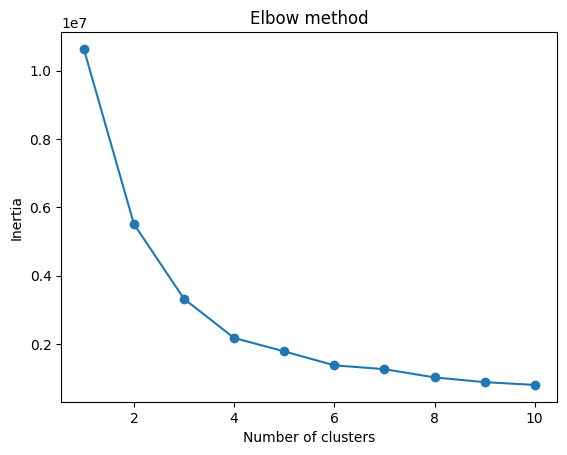

In [571]:
inertias = []
for k in range(1, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    inertias.append(kmeans.inertia_)

# Affichage du graphique du coude
plt.plot(range(1, 11), inertias, marker='o')
plt.xlabel('Number of clusters')
plt.ylabel('Inertia')
plt.title('Elbow method')
plt.show()


Using the elbow method, it seems good to take 4 clusters

**Silhouette Method**

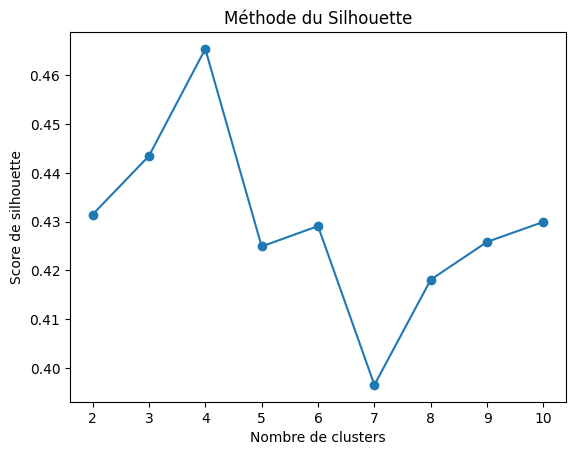

In [572]:
silhouette_scores = []
for k in range(2, 11):
    kmeans = KMeans(n_clusters=k, random_state=42)
    kmeans.fit(X)
    score = silhouette_score(X, kmeans.labels_)
    silhouette_scores.append(score)

# Affichage des scores de silhouette
plt.plot(range(2, 11), silhouette_scores, marker='o')
plt.xlabel('Nombre de clusters')
plt.ylabel('Score de silhouette')
plt.title('Méthode du Silhouette')
plt.show()

Using the silhouette method, it seems good to take 4 clusters




**K-means**

In [573]:
kmeans = KMeans(n_clusters=4, random_state=0)
X['cluster'] = kmeans.fit_predict(X)
print(X['cluster'].value_counts())

cluster
3    2186
1    1959
0    1736
2    1151
Name: count, dtype: int64


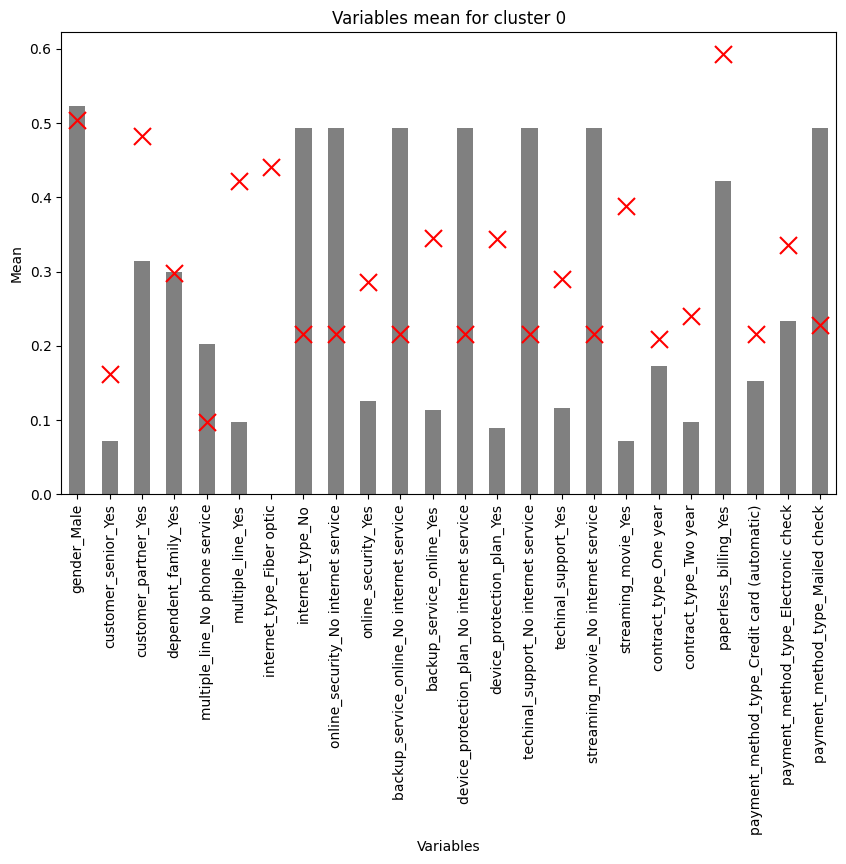

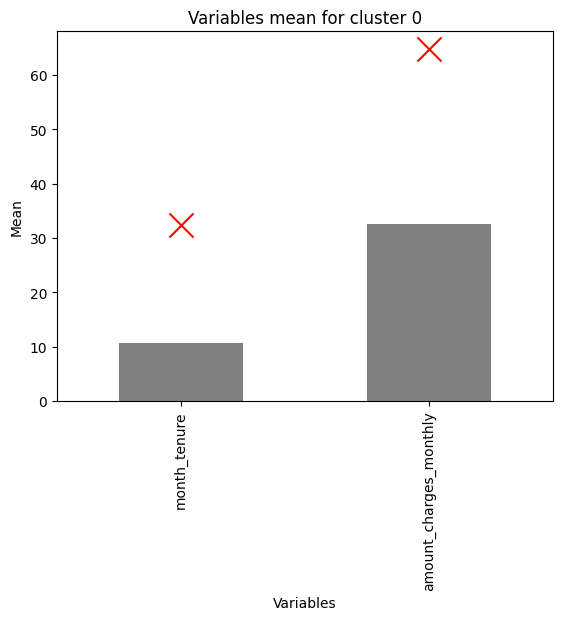

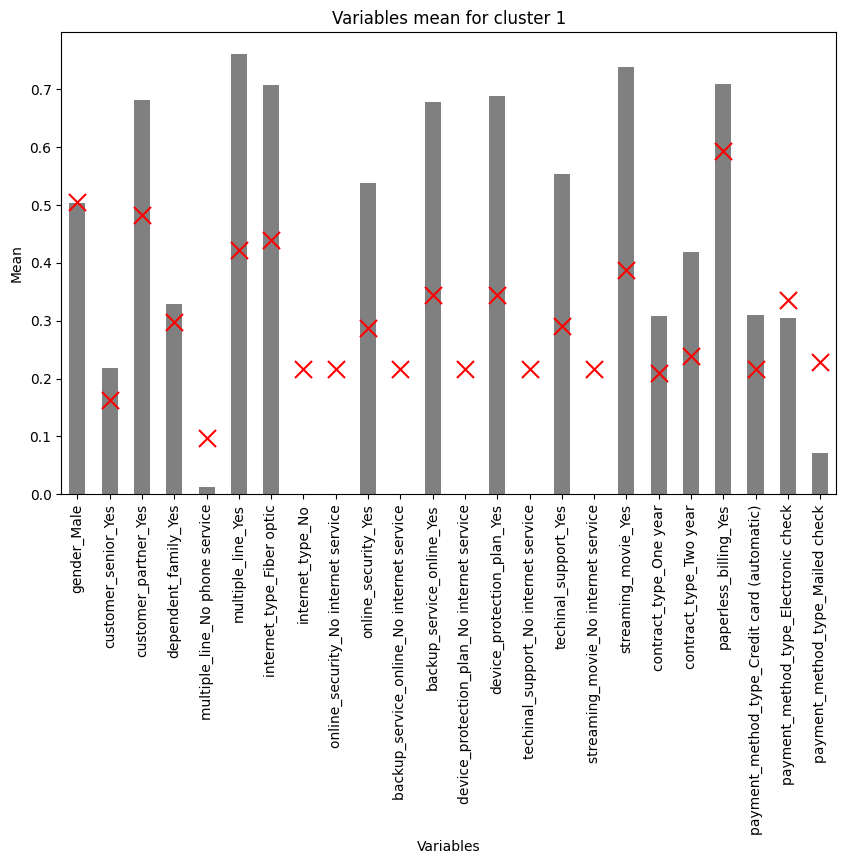

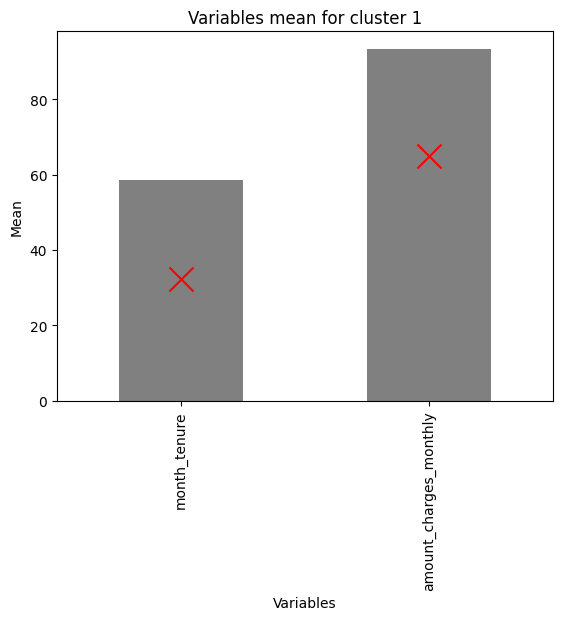

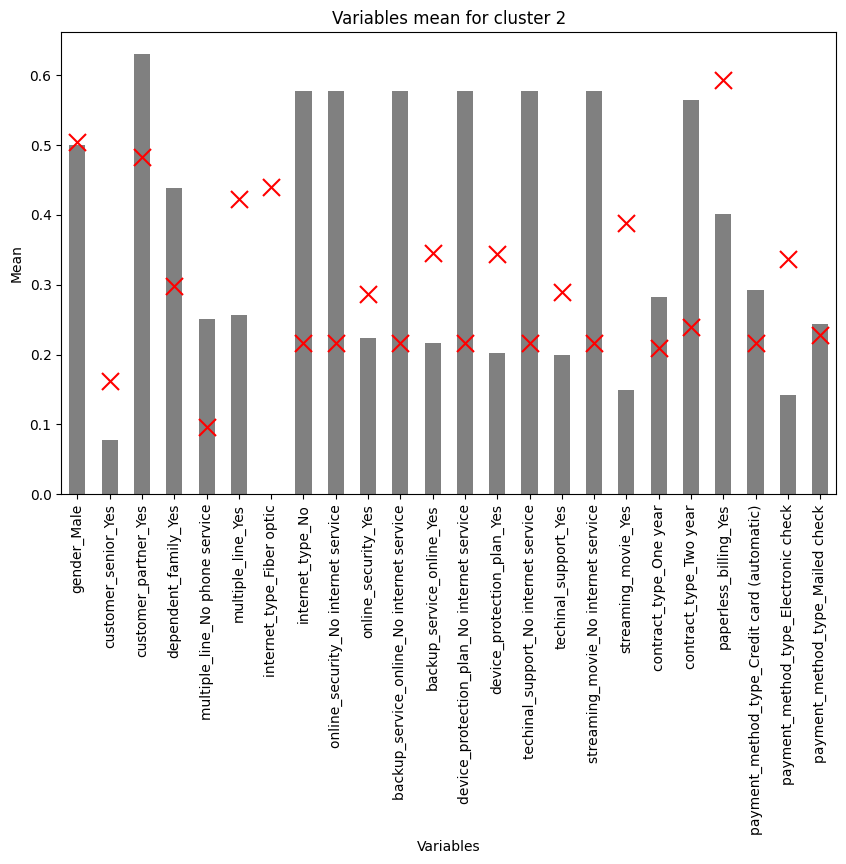

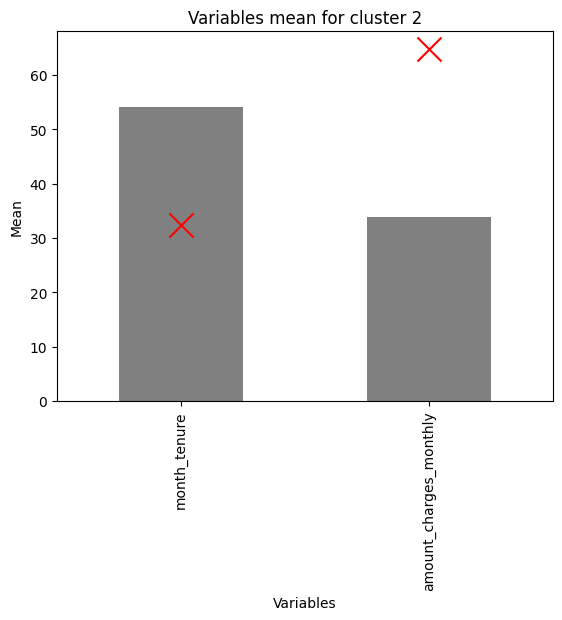

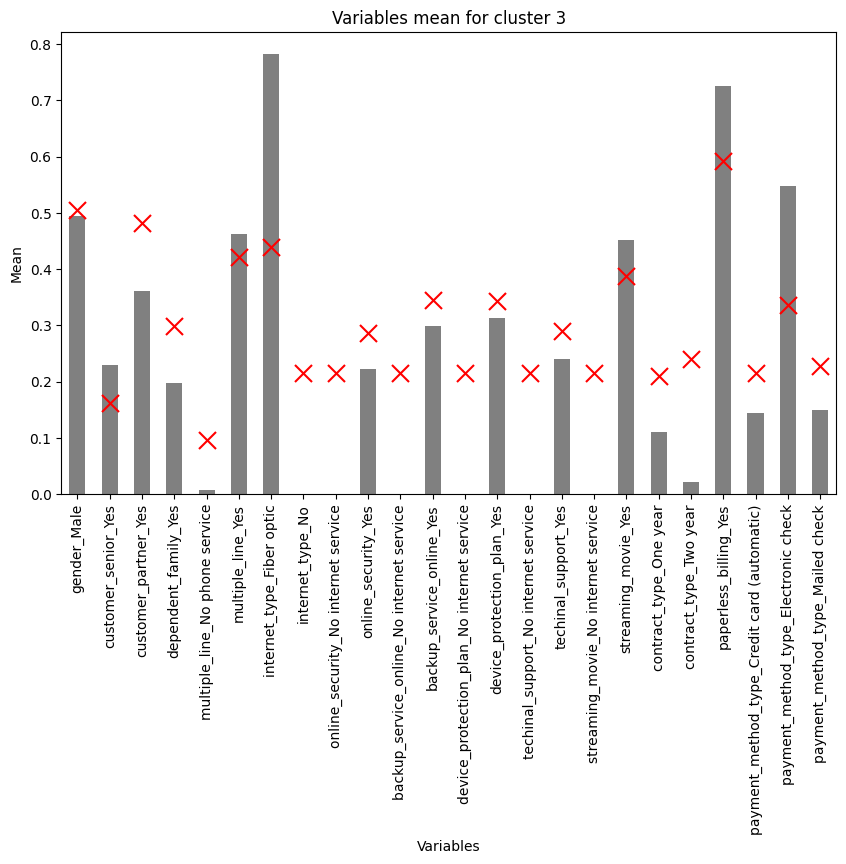

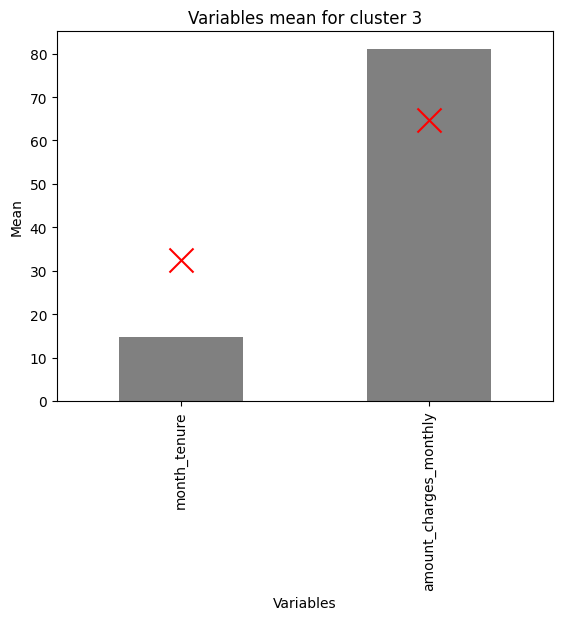

In [574]:
cluster_stats = X.groupby('cluster').mean()
clusters = cluster_stats.index

global_means = X.drop(columns='cluster').mean()  # Enlève la colonne 'cluster' pour calculer la moyenne générale


for cluster in clusters:
    plt.figure(figsize=(10, 6))
    cluster_data = cluster_stats.loc[cluster]

    # Categorival variables
    cluster_data.iloc[2:].plot(kind='bar', color = 'grey')

    for i, variable in enumerate(cluster_data.iloc[2:].index):
        plt.scatter(x=i, y=global_means[variable], color='red', marker='x', s=150,
                    label=f'Moyenne {variable}' if i == 0 else "")    
        
    plt.title(f'Variables mean for cluster {cluster}')
    plt.xlabel('Variables')
    plt.ylabel('Mean')
    plt.xticks(rotation=90)
    plt.show()

    # Numerical variables
    cluster_data.iloc[:2].plot(kind='bar', color = 'grey')

    for i, variable in enumerate(cluster_data.iloc[:2].index):
        plt.scatter(x=i, y=global_means[variable], color='red', marker='x', s=300,
                    label=f'Moyenne {variable}' if i == 0 else "")    
    
    plt.title(f'Variables mean for cluster {cluster}')
    plt.xlabel('Variables')
    plt.ylabel('Mean')
    plt.xticks(rotation=90)
    plt.show()

**Clusters interpretation :**

- `Cluster 0`: 

